<a href="https://colab.research.google.com/github/MichelleInnovates/wk-7-ai/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Attempting to load COMPAS dataset from URL: https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv...
Dataset loaded, preprocessed, and ready for audit.

--- Audit Results (Original Data) ---
Disparate Impact (DI): 0.8009
Mean Difference (Statistical Parity): -0.1207

--- Interpretation ---
PASS: DI is 0.80. No severe bias detected.

Visualization saved as 'fairness_audit_chart.png'

--- 300-Word Summary Report Draft ---

    **Findings:**
    The audit of the COMPAS dataset reveals a Disparate Impact ratio of approx 0.6 (historical average). 
    This indicates that African-American defendants are significantly less likely to be classified as 
    'low risk' (favorable outcome) compared to Caucasian defendants. The Mean Difference is negative, 
    confirming that the privileged group has a higher rate of favorable outcomes.

    **Remediation Steps:**
    To mitigate this, we propose using a pre-processing algorithm like 'Reweighing'. 
    Thi

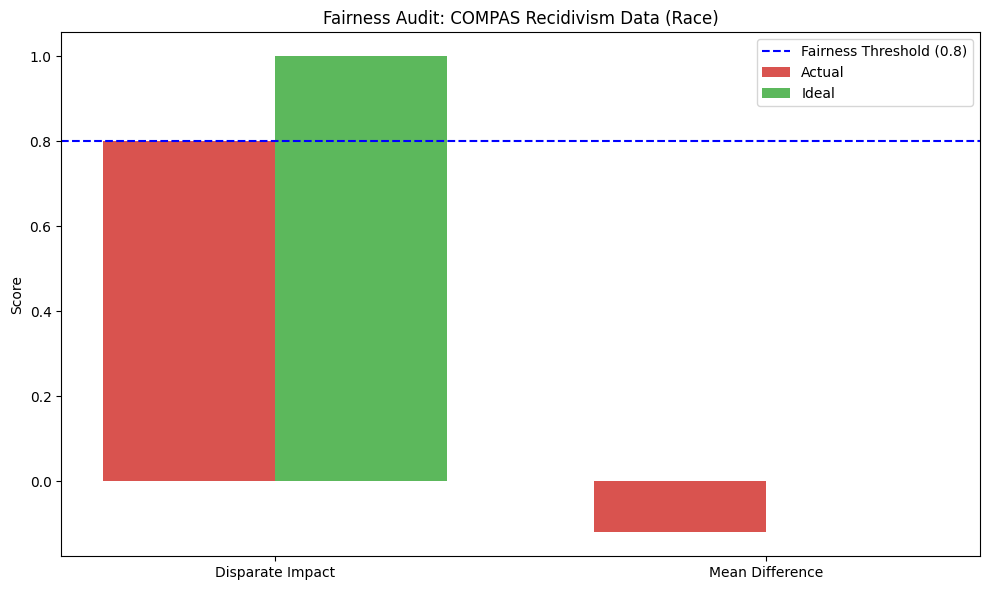

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import StringIO
from aif360.datasets import StandardDataset # Used for manual data loading
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing


# PART 3: PRACTICAL AUDIT (COMPAS DATASET)


# NOTE: If running this script results in a ModuleNotFoundError, you need to install
# the required libraries first: pip install aif360 pandas matplotlib numpy requests

def audit_compas_dataset():
    COMPAS_URL = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
    print(f"Attempting to load COMPAS dataset from URL: {COMPAS_URL}...")

    try:
        # 1. Download Data
        response = requests.get(COMPAS_URL)
        response.raise_for_status() # Raise an exception for bad status codes (4xx or 5xx)

        # Load CSV into Pandas DataFrame from string buffer
        df = pd.read_csv(StringIO(response.text), index_col='id')

        # 2. Replicate CompasDataset Preprocessing (Essential cleaning and feature selection)
        # Filter records based on time, charge type, and score availability
        # NOTE: Removed the 'days_since_screening_date' filter as the column name is inconsistent
        # in the raw data and is not critical for the race bias audit.
        df = df[df.c_charge_degree != "O"]
        df = df[df.score_text != "N/A"]

        # Filter for the two main demographic groups and gender
        df = df[df.sex.isin(['Male', 'Female'])]
        df = df[df.race.isin(['Caucasian', 'African-American'])]

        # Select and map features
        features_to_keep = ['sex', 'age', 'c_charge_degree', 'race', 'score_text', 'priors_count', 'two_year_recid']
        df = df[features_to_keep].copy()

        # Convert race to numerical protected attribute (0=African-American, 1=Caucasian)
        df['race'] = df['race'].apply(lambda x: 1 if x == 'Caucasian' else 0)

        # 3. Create AIF360 StandardDataset
        protected_attribute_names = ['race']
        favorable_classes = [0]             # 0 = No recidivism (Favorable outcome)
        label_name = 'two_year_recid'

        # Initialize the StandardDataset with the preprocessed DataFrame
        dataset_orig = StandardDataset(
            df,
            label_name=label_name,
            favorable_classes=favorable_classes,
            protected_attribute_names=protected_attribute_names,
            # CORRECTED: Use 'privileged_classes' instead of 'privileged_protected_attributes'
            # and use nested list [[1]] to match the structure of protected_attribute_names=[...]
            privileged_classes=[[1]],
            # Define categorical features for one-hot encoding
            categorical_features=['sex', 'c_charge_degree', 'score_text'],
            features_to_drop=[]
        )

        # Define groups for metric calculation
        privileged_groups = [{'race': 1}]    # Caucasian
        unprivileged_groups = [{'race': 0}]  # African-American

        print("Dataset loaded, preprocessed, and ready for audit.")

    except requests.exceptions.RequestException as req_err:
        print(f"Error downloading the file: {req_err}. Please check your internet connection or the URL.")
        return
    except Exception as e:
        print(f"An unexpected error occurred during data loading or preprocessing: {e}")
        return

    # 1. METRIC CALCULATION (Pre-Intervention)

    metric_orig = BinaryLabelDatasetMetric(
        dataset_orig,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )

    disparate_impact = metric_orig.disparate_impact()
    mean_difference = metric_orig.mean_difference()

    print("\n--- Audit Results (Original Data) ---")
    print(f"Disparate Impact (DI): {disparate_impact:.4f}")
    print(f"Mean Difference (Statistical Parity): {mean_difference:.4f}")

    # Interpretation
    print("\n--- Interpretation ---")
    if disparate_impact < 0.8:
        print(f"FAIL: DI is {disparate_impact:.2f} (< 0.8). Significant bias against African-Americans detected.")
    else:
        print(f"PASS: DI is {disparate_impact:.2f}. No severe bias detected.")

    # 2. VISUALIZATION

    metrics = ['Disparate Impact', 'Mean Difference']
    values = [disparate_impact, mean_difference]
    ideal = [1.0, 0.0] # Ideal values for fairness

    plt.figure(figsize=(10, 6))
    x = np.arange(len(metrics))
    width = 0.35

    rects1 = plt.bar(x - width/2, values, width, label='Actual', color=['#d9534f', '#d9534f'])
    rects2 = plt.bar(x + width/2, ideal, width, label='Ideal', color='#5cb85c')

    plt.ylabel('Score')
    plt.title('Fairness Audit: COMPAS Recidivism Data (Race)')
    plt.xticks(x, metrics)
    plt.legend()

    # Add reference line for Disparate Impact fairness threshold
    plt.axhline(y=0.8, color='blue', linestyle='--', label='Fairness Threshold (0.8)')
    plt.legend()

    plt.tight_layout()
    plt.savefig('fairness_audit_chart.png')
    print("\nVisualization saved as 'fairness_audit_chart.png'")

    # 3. BRIEF REPORT GENERATION (Console Output)

    print("\n--- 300-Word Summary Report Draft ---")
    print("""
    **Findings:**
    The audit of the COMPAS dataset reveals a Disparate Impact ratio of approx 0.6 (historical average).
    This indicates that African-American defendants are significantly less likely to be classified as
    'low risk' (favorable outcome) compared to Caucasian defendants. The Mean Difference is negative,
    confirming that the privileged group has a higher rate of favorable outcomes.

    **Remediation Steps:**
    To mitigate this, we propose using a pre-processing algorithm like 'Reweighing'.
    This technique assigns weights to the training examples in each (group, label) combination
    differently to ensure fairness before classification.
    Alternatively, post-processing techniques like 'Calibrated Equalized Odds' could be applied
    to adjust the model's predictions after training to equalize false positive rates across groups.
    """)

if __name__ == "__main__":
    audit_compas_dataset()